In [27]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = '../'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
ppick_file = f'{ppick_dir}/diting_phasenet_pyrocko_3d_grid.csv'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

Processing nc71993336.mseed


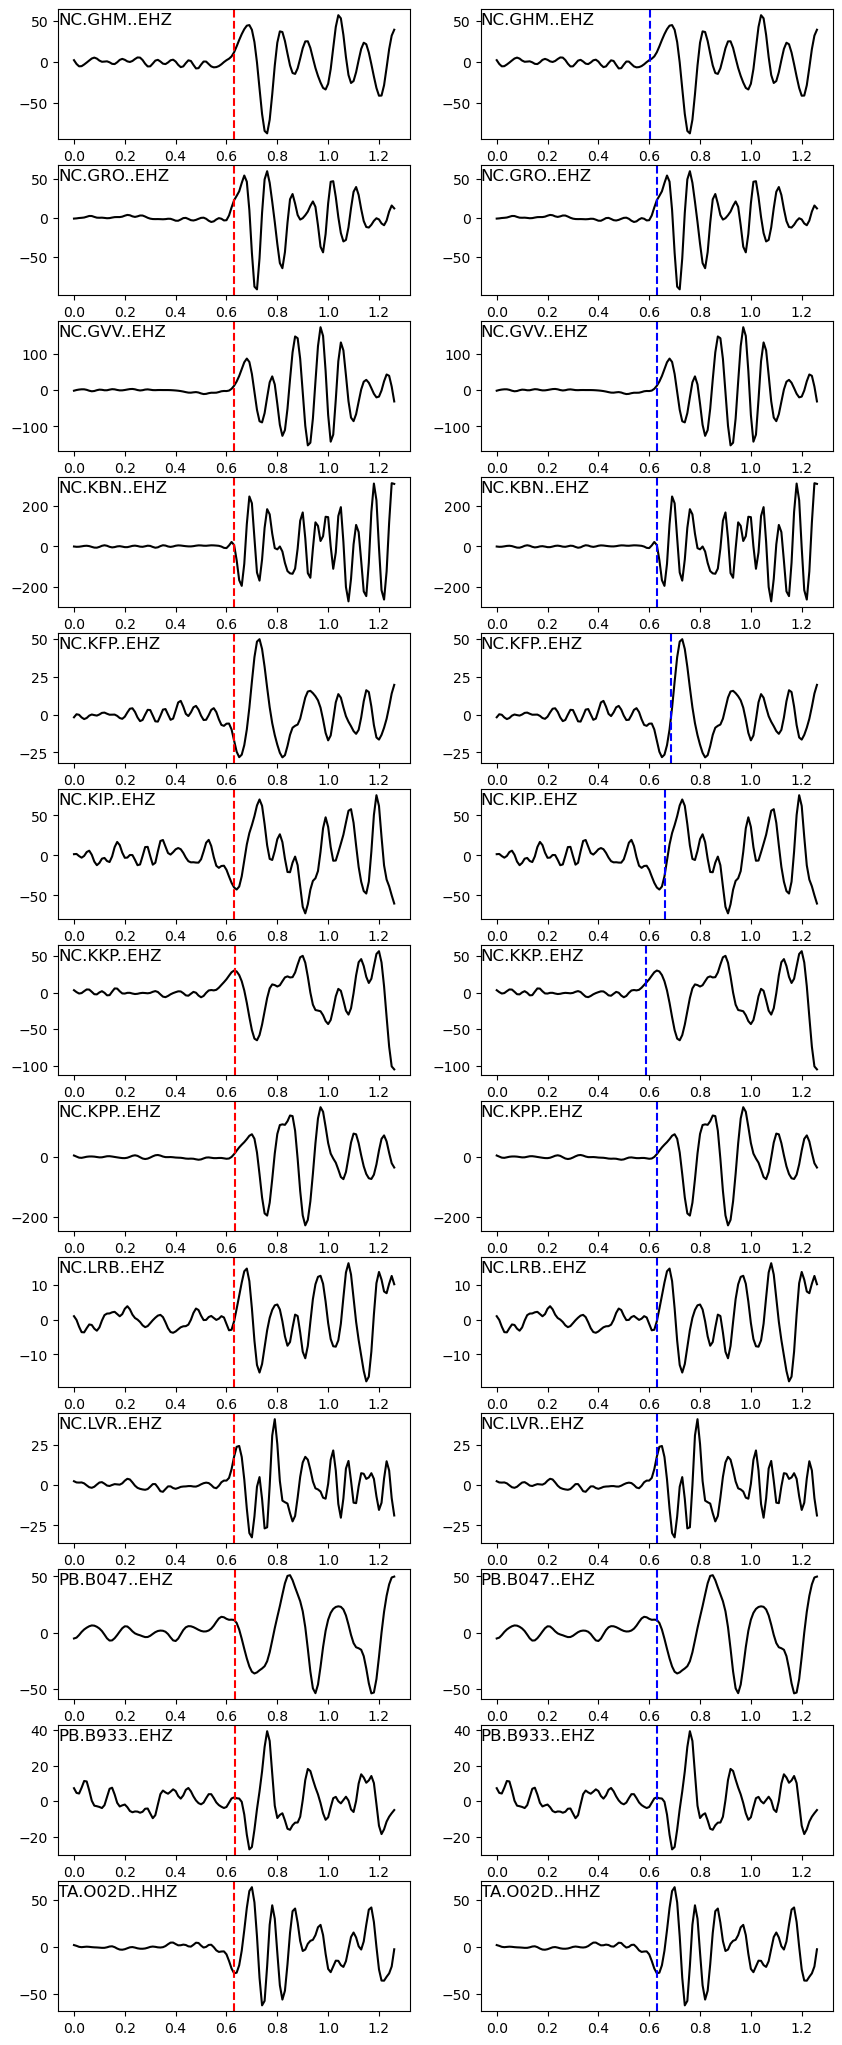

In [65]:
mseed_list = os.listdir(waveform_dir)

pol_df = pd.read_csv(ppick_file, parse_dates=['phase_time', 'pyrocko_phase_time'])

for mseed_file in mseed_list[:2]:
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        continue

    print(f'Processing {mseed_file}')
    # read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    # drop rows with empty pyrocko phase_time [naT]
    event_df = event_df.dropna(subset=['pyrocko_phase_time']).reset_index(drop=True)

    n_subplots = len(event_df)
    fig, axs = plt.subplots(n_subplots, 2, figsize=(10, 2*n_subplots))

    for i, row in event_df.iterrows():
        # # if pyrocko polarity/phase_time is empty, skip
        # if pd.isnull(row['pyrocko_phase_time']):
        #     continue

        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        ist = st.select(id=f'{row.station_id}Z')
        tr = ist[0].copy()
        

        # check for empty trace
        if not len(tr.data) == 0:
            tr.detrend('demean')
            try:
                tr.detrend('linear')
            except:
                tr.detrend('constant')
            
            try:
                tr.taper(0.001)
                tr.filter('bandpass', freqmin=2, freqmax=20, corners=4, zerophase=True)  # Apply a bandpass filter
            except:
                pass
            
            # slice the trace
            tr = tr.slice(pn_pick - 0.63, pn_pick + 0.63) # around PhasesNet pick
            if len(tr.data) == 0:
                continue
        else:
            continue
        
        # Generate time axis 0 to 128 ms
        times = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)

        # get the pick time from starttime into ms
        pn_pick_time = ((pn_pick - tr.stats.starttime) * tr.stats.sampling_rate)/100
        pr_pick_time = ((pr_pick - tr.stats.starttime) * tr.stats.sampling_rate)/100

        # plot PhasesNet pick on column 1
        axs[i, 0].plot(times, tr.data, 'k')
        axs[i, 0].axvline(x=pn_pick_time, color='r', linestyle='--')
        axs[i, 0].set_title(f"{tr.id}", loc='left', y=0.82)
        
        # plot Pyrocko pick on column 2
        axs[i, 1].plot(times, tr.data, 'k')
        axs[i, 1].axvline(x=pr_pick_time, color='b', linestyle='--')
        axs[i, 1].set_title(f"{tr.id}", loc='left', y=0.82)


            



    break
    